# Introduction to RNN

Notebook to do basic models with recurrent neural networks.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

## Basic RNN

First a RNN with a trivial sequence of numbers.

In [26]:
data = torch.linspace(1,20,20)
print("Data: ", data.shape, "\n\n", data)


Data:  torch.Size([20]) 

 tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20.])


For a RNN, we need to define sequence length, batch size, and input size. In this example, we will predict the next two numbers based on five contiguous numbers of the sequence.

We have only a univariate time serie (data with only one column), and the problem is basically to observe a sequence of length of five inputs to predict the next two outputs.

In [27]:
# Number of features used as input. (e.g # of columns)
INPUT_SIZE = 1

# Number of previous time records taken into account.
SEQ_LENGTH = 5

# Number of features in last hidden state i.e. number of output time-
# steps to predict.
HIDDEN_SIZE = 2

# Number of stacked rnn layers.
NUM_LAYERS = 1

# We have total of 20 events in our input. 
# We divide the input into 4 batches where each batch has only 1
# event. Each event corresponds to a sequence of length 5. 
BATCH_SIZE = 4

In [28]:
# Initialize the RNN of one input,one hidden layer of 5 features
rnn = nn.RNN(input_size=1, 
             hidden_size=5,
             num_layers=1,
             batch_first=True)

# flatten input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)

# resulting sizes:
# for out, shape: (batch, seq_len, num_directions * hidden_size)
# for h_n, shape: (num_layers * num_directions, batch, hidden_size)
for i in range(100):
    out, h_n = rnn(inputs)

We can use the data as input and obtain the output and the hidden state using the following. The size of the input depends on batch size, sequence length, and input size – the parameters we defined previously. `nn.RNN()` can also accept preset values for hidden layer, which are default to zeros if not specified.

The output is the tensor containing output of the RNN from all time steps from the last RNN layer. The output shape is (sequence length, batch, num_directions * hidden size), where num_directions is 2 for bidirectional RNNs, otherwise 1.

In [29]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)

Input:  torch.Size([4, 5, 1]) 
 tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.]],

        [[ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]],

        [[11.],
         [12.],
         [13.],
         [14.],
         [15.]],

        [[16.],
         [17.],
         [18.],
         [19.],
         [20.]]])

Output:  torch.Size([4, 5, 5]) 
 tensor([[[ 2.2940e-01, -7.6961e-02,  1.0346e-02,  1.6422e-01,  4.3563e-02],
         [ 3.2742e-01, -1.1641e-01,  6.7766e-02,  4.4944e-01,  3.5339e-01],
         [ 2.7349e-01, -1.1461e-01,  2.4001e-01,  6.6414e-01,  5.5228e-01],
         [ 2.6506e-01, -7.7366e-02,  3.8044e-01,  8.0930e-01,  6.7186e-01],
         [ 3.1545e-01, -6.2626e-02,  4.8856e-01,  8.9479e-01,  7.7150e-01]],

        [[ 5.9960e-01,  1.7712e-02,  3.0440e-01,  9.1821e-01,  8.0508e-01],
         [ 5.0046e-01, -1.4334e-01,  6.2679e-01,  9.6626e-01,  9.1806e-01],
         [ 5.5172e-01, -2.5542e-04,  6.7514e-01,  9.8004e-01,  9.3187e-0

# Forecasting COVID19 Cases with an LSTM

Let's go through a real data example. In this example, we will use one of the data sources available publicly with COVID statistics. 
The database contains COVID statistics in terms of cases and death in each country. The details are specified per date and can be understood as sequential tabular data. The data is being fetched from the European Centre for Disease Prevention and Control. 

In [30]:
!wget https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv -O coviddata.csv

--2023-03-28 23:58:11--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv
Resolving opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)... 88.131.255.63
Connecting to opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)|88.131.255.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4307302 (4.1M) [application/octet-stream]
Saving to: ‘coviddata.csv’

coviddata.csv       100%[===================>]   4.11M  17.7MB/s    in 0.2s    

2023-03-28 23:58:12 (17.7 MB/s) - ‘coviddata.csv’ saved [4307302/4307302]



In [31]:
df = pd.read_csv("coviddata.csv")
df

dateRep  day  month  year  cases  deaths countriesAndTerritories  \
0      14/12/2020   14     12  2020    746       6             Afghanistan   
1      13/12/2020   13     12  2020    298       9             Afghanistan   
2      12/12/2020   12     12  2020    113      11             Afghanistan   
3      11/12/2020   11     12  2020     63      10             Afghanistan   
4      10/12/2020   10     12  2020    202      16             Afghanistan   
...           ...  ...    ...   ...    ...     ...                     ...   
61895  25/03/2020   25      3  2020      0       0                Zimbabwe   
61896  24/03/2020   24      3  2020      0       1                Zimbabwe   
61897  23/03/2020   23      3  2020      0       0                Zimbabwe   
61898  22/03/2020   22      3  2020      1       0                Zimbabwe   
61899  21/03/2020   21      3  2020      1       0                Zimbabwe   

      geoId countryterritoryCode  popData2019 continentExp  \
0        AF                  AFG   38041757.0         Asia   
1        AF                  AFG   38041757.0         Asia   
2        AF                  AFG   38041757.0         Asia   
3        AF                  AFG   38041757.0         Asia   
4        AF                  AFG   38041757.0         Asia   
...     ...                  ...          ...          ...   
61895    ZW                  ZWE   14645473.0       Africa   
61896    ZW                  ZWE   14645473.0       Africa   
61897    ZW                  ZWE   14645473.0       Africa   
61898    ZW                  ZWE   14645473.0       Africa   
61899    ZW                  ZWE   14645473.0       Africa   

       Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                               9.013779           
1                                               7.052776           
2                                               6.868768           
3                                               7.134266           
4                                               6.968658           
...                                                  ...           
61895                                                NaN           
61896                                                NaN           
61897                                                NaN           
61898                                                NaN           
61899                                                NaN           

[61900 rows x 12 columns]

Let's first limit our data to Canada for a prediction model, and set it as a pandas Series indexed with time.

In [32]:
data = df[df['countryterritoryCode'] == 'CAN'][['dateRep', 'cases']]
data

dateRep  cases
10316  14/12/2020   5891
10317  13/12/2020   6011
10318  12/12/2020   6772
10319  11/12/2020   6739
10320  10/12/2020   6295
...           ...    ...
10661  04/01/2020      0
10662  03/01/2020      0
10663  02/01/2020      0
10664  01/01/2020      0
10665  31/12/2019      0

[350 rows x 2 columns]

In [33]:
data['dateRep'] = pd.to_datetime(data['dateRep'], format="%d/%m/%Y")
data = data.sort_values(by="dateRep", key=pd.to_datetime)
data = data.set_index('dateRep')
data

cases
dateRep          
2019-12-31      0
2020-01-01      0
2020-01-02      0
2020-01-03      0
2020-01-04      0
...           ...
2020-12-10   6295
2020-12-11   6739
2020-12-12   6772
2020-12-13   6011
2020-12-14   5891

[350 rows x 1 columns]

<Axes: title={'center': 'COVID19 cases in Canada'}, xlabel='dateRep'>

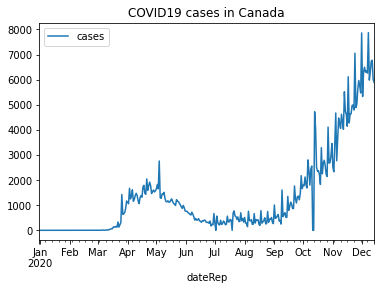

In [34]:
data.plot(title='COVID19 cases in Canada')

We need to select chunks of sequences. Say, the data is from a certain week starting from Sunday.
We will create a function that accepts a NumPy array and an integer for the sequence length and returns the chunks of sequence length. 

For example, [1,2,3,4,5,6] of sequence length 3 should create chunks as [1,2,3], [2,3,4], [3,4,5], and [4,5,6]. However, in this problem, we also want to predict the next element; that is, 1,2,3 should be followed by 4.

In [35]:
def chunkify(data, seq_length):
    chunks = []
    targets = []

    for i in range(len(data)-seq_length-1):
        chunks.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(chunks), np.array(targets)

chunkify([[1],[2],[3],[4],[5],[6]],3)

(array([[[1],
         [2],
         [3]],
 
        [[2],
         [3],
         [4]]]), array([[4],
        [5]]))

Preprocessing of the data would also require to scale the data to the right values. We can use `MinMaxScaler` from `scikit-learn`. We will reserve 80% of the data as training set and keep a sequence length of 5.

In [36]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(data.values.copy())

seq_length = 5
x, y = chunkify(training_data, seq_length)

train_size = int(len(y) * 1)
test_size = len(y) - train_size

# split the data in torch tensors
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Now let's build our LSTM model. If `num_layers` is specified, the model will stack that number of LSTMs together so that the output of the first LSTM is provided to the second LSTM, and so on. As this is a regression problem, we use the MSE as loss and linear outputs.

We keep the structure simple and have one LSTM layer, followed by fully connected output. In forward() method, we will start by creating a hidden state and cell memory initialized with zeros. The output of LSTM will be applied to the fully connected layer and returned as output.

In [37]:
class CovidPrediction(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(CovidPrediction, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
      
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
      
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [38]:
# show the model
model = CovidPrediction(1, 1, 4, 1)
print(model)

CovidPrediction(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [39]:
num_epochs = 100
learning_rate = 0.01
model = CovidPrediction(1, 1, 2, 1)

criterion = torch.nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch%10==0:
        print("Iteration: %d, loss:%f" % (epoch, loss.item()))

Iteration: 0, loss:0.149131
Iteration: 10, loss:0.062302
Iteration: 20, loss:0.040898
Iteration: 30, loss:0.036923
Iteration: 40, loss:0.030625
Iteration: 50, loss:0.019917
Iteration: 60, loss:0.009133
Iteration: 70, loss:0.005554
Iteration: 80, loss:0.005322
Iteration: 90, loss:0.004331


## Predictions from the model

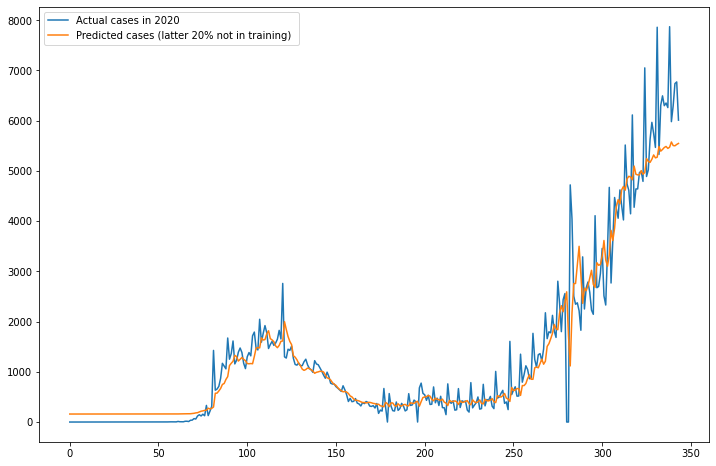

In [40]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
data_actual = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
data_actual = scaler.inverse_transform(data_actual)

# plt.axvline(x=train_size, c='r', linestyle='--')
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data_actual)
plt.plot(data_predict)
plt.suptitle('')
plt.legend(['Actual cases in 2020', 'Predicted cases (latter 20% not in training) '], loc='upper left')

Let's see how our trained model performs on another country, i.e. USA

In [47]:
data = df[df['countryterritoryCode']=='ZW'][['dateRep', 'cases']]
data['dateRep'] = pd.to_datetime(data['dateRep'], format="%d/%m/%Y")
data = data.sort_values(by="dateRep", key=pd.to_datetime)
data = data.set_index('dateRep')

In [48]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(data.values.copy())
x, y = chunkify(training_data, seq_length)
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))


ValueError: ignored

In [49]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
data_actual = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
data_actual = scaler.inverse_transform(data_actual)

# plt.axvline(x=train_size, c='r', linestyle='--')
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data_actual)
plt.plot(data_predict)
plt.suptitle('')
plt.legend(['Actual Covid-19 cases in USA in 2020', 'Predicted cases of Covid-19'],
           loc='upper left')

NotFittedError: ignored

Stuff to play with:

1. Find why we are not so good in our predictions
2. Play with the hyper-parameters of the LSTM
3. See when we add more data, from multiple countries.